In [1]:
# Jannik's models are not SAE Lens, so use Baukit
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# tiny model is in a different direction, add current one to path
import sys
from pathlib import Path
# Get the parent directory of current_dir
parent_dir = str(Path("/root/GroupedSAEs/notebooks/tiny_circuits.ipynb").parent.parent)
sys.path.append(parent_dir)
# from tiny_model.tiny_model import TinyModel, tokenizer
# from nnsight import NNsight
from tiny_model import TinyModel, tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llm = TinyModel().to(device)

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/tokenization/tokenization.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

In [2]:
from datasets import load_dataset, Dataset
from tqdm import tqdm
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text)
    print(dataset)
    total_failed_tokens = 0
    all_tokens = []
    for text in tqdm(dataset["text"]):
        try:
            tokens = [9996] + tokenizer.encode(text)[:max_length]
        except:
            total_failed_tokens += 1
            continue
        # only include if it's at least max_length
        if len(tokens) == max_length+1:
            all_tokens.append(tokens)
    print(f"Failed to tokenize {total_failed_tokens} tokens")
    # convert into a dataset class
    return  Dataset.from_dict({"input_ids": all_tokens})


dataset_name = "noanabeshima/TinyStoriesV2"
max_seq_length = 100
num_datapoints = 10000
# max_seq_length = 100
# num_datapoints = 500
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)
true_num_datapoints = len(dataset)
# added BOS
max_seq_length +=1
total_tokens = max_seq_length * true_num_datapoints
print(f"Number of datapoints w/ {max_seq_length} tokens: {true_num_datapoints}")
print(f"Total Tokens: {total_tokens / 1e6}M")


Dataset({
    features: ['text'],
    num_rows: 10000
})


100%|██████████| 10000/10000 [00:15<00:00, 654.75it/s]


Failed to tokenize 0 tokens
Number of datapoints w/ 101 tokens: 9969
Total Tokens: 1.006869M


In [3]:
#set torch grad to zero globally
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from tiny_model import parse_mlp_tag, SparseMLP
N = 1
# activation_names = [f"A{N}", f"T{N}"]
# activation_names = [f"A{N}", f"A{N+1}"]
# activation_names = [f"T{N}", f"T{N+1}"]
activation_names = [f"Rm{N}_S-3_R1_P0", f"T{N}"]
file, _, _, _ = parse_mlp_tag(activation_names[0])
sae_upstream = SparseMLP.from_pretrained(file)
file, _, _, _ = parse_mlp_tag(activation_names[1])
sae_downstream = SparseMLP.from_pretrained(file)

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [4]:
batch_size = 128
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)

In [5]:
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear_second = nn.Linear(hidden_size, output_size, bias=bias)
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
    
    def forward(self, x):
        output = self.linear_first(x)
        output = torch.relu(output)
        output = self.linear_second(output)
        return output


Training (Epoch 1/1):   0%|          | 0/78 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

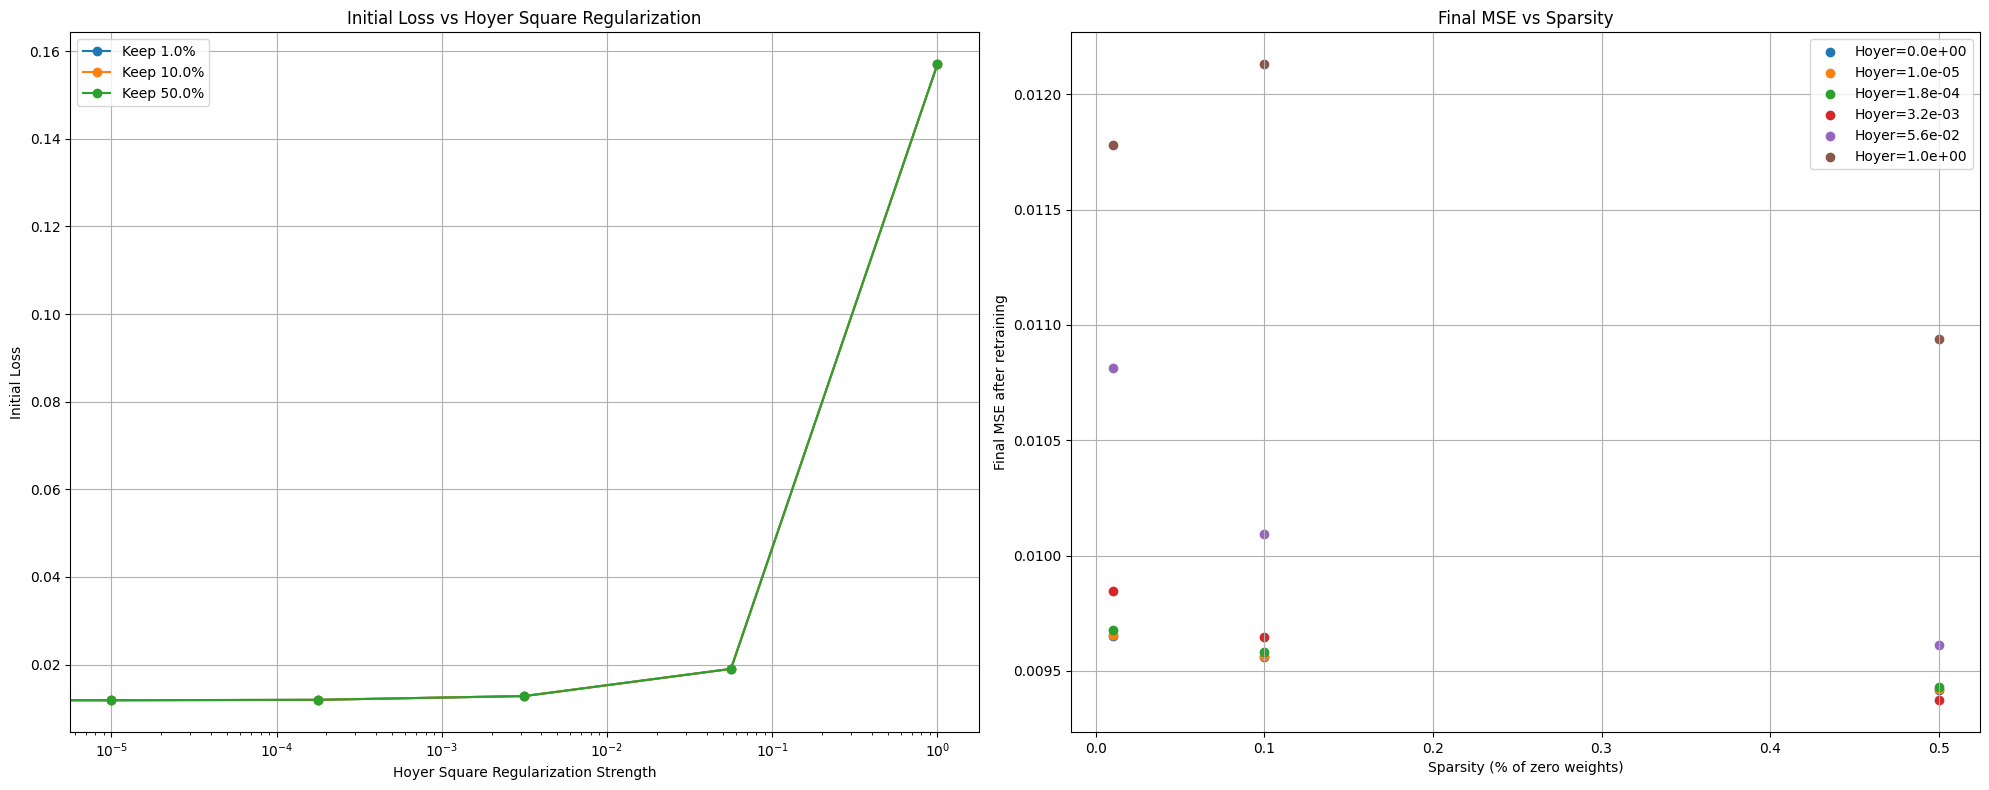

Best initial loss: 0.0119 (Hoyer=0.00e+00, Keep=1.00%)
Best sparsity: 50.00% (Hoyer=0.00e+00, Keep=50.00%)
Best final loss after retraining: 0.0094 (Hoyer=3.16e-03, Keep=50.00%, Sparsity=50.00%)


In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy


def hoyer_square(w):
    """Calculate Hoyer Square for a tensor."""
    num_elements = w.numel()
    return (torch.sum(torch.abs(w)) ** 2) / (num_elements * torch.sum(w ** 2))

def train_model(model, dl, device, mask=None, hoyer_lambda=0, epochs=1):
    if mask is None:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    else:
        opt = torch.optim.Adam([{'params': model.linear.weight, 'mask': mask}], lr=1e-3)
    
    losses = []
    
    for epoch in range(epochs):
        for batch_ind, batch in enumerate(tqdm(dl, desc=f"{'Training' if mask is None else 'Retraining'} (Epoch {epoch+1}/{epochs})")):
            batch = batch.to(device)
            with torch.no_grad():
                feature_acts_upstream = llm[activation_names[0]](batch)
                feature_acts_downstream = llm[activation_names[1]](batch)
                feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
                feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            mse_loss = torch.mean(residual**2)
            
            if mask is None and hoyer_lambda > 0:
                # Calculate Hoyer Square regularization only during initial training
                hoyer_reg = hoyer_square(model.linear.weight)
                loss = mse_loss + hoyer_lambda * hoyer_reg
            else:
                loss = mse_loss
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if mask is not None:
                # Ensure zero weights remain zero during retraining
                with torch.no_grad():
                    model.linear.weight.data[~mask] = 0
            
            losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, keep_percent):
    with torch.no_grad():
        weights = model.linear.weight.data
        num_elements = weights.numel()
        k = int(num_elements * (1 - keep_percent))
        
        # Flatten the weights
        flat_weights = weights.view(-1)
        
        # Use torch.topk to find the threshold value
        threshold = torch.topk(torch.abs(flat_weights), k, largest=False)[0][-1]
        
        # Create the mask
        mask = torch.abs(weights) >= threshold
        weights[~mask] = 0
    return mask

def get_sparsity(model):
    total_params = model.linear.weight.numel()
    zero_params = (model.linear.weight == 0).sum().item()
    return zero_params / total_params

def evaluate_model(model, dl, device, num_batches=3):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dl):
            if i >= num_batches:
                break
            batch = batch.to(device)
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            loss = torch.mean(residual**2)
            total_loss += loss.item()
    return total_loss / num_batches

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

hoyer_values = [0] + list(np.logspace(-5, 0, 5))  # Include 0 for no regularization
keep_percents = [0.01, 0.1, 0.5]  # Range of keep percentages

results = []

import gc
import torch

for hoyer_lambda in hoyer_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    initial_loss = train_model(model, dl, device, hoyer_lambda=hoyer_lambda)
    
    for keep_percent in keep_percents:
        # Move model to CPU for copying and thresholding
        # print(f"Training model with Hoyer={hoyer_lambda:.2e}, Keep={keep_percent:.2%}")
        model = model.cpu()
        with torch.no_grad():
            model_copy = deepcopy(model)
            mask = threshold_weights(model_copy, keep_percent)
            # sparsity = get_sparsity(model_copy)
            sparsity = keep_percent
        
        # Move model_copy back to GPU for training
        model_copy = model_copy.to(device)
        mask = mask.to(device)
        # print("After it")
        retrained_loss = train_model(model_copy, dl, device, mask=mask, hoyer_lambda=0)
        final_loss = evaluate_model(model_copy, dl, device)
        
        results.append((hoyer_lambda, keep_percent, initial_loss, sparsity, retrained_loss, final_loss))
        
        # Clear GPU memory
        del model_copy, mask
        torch.cuda.empty_cache()
        gc.collect()
    
    # Clear GPU memory after each hoyer_lambda iteration
    del model
    torch.cuda.empty_cache()
    gc.collect()
# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial loss vs Hoyer regularization
for keep_percent in keep_percents:
    mask = results_array[:, 1] == keep_percent
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Keep {keep_percent:.1%}')

ax1.set_xlabel('Hoyer Square Regularization Strength')
ax1.set_ylabel('Initial Loss')
ax1.set_title('Initial Loss vs Hoyer Square Regularization')
ax1.legend()
ax1.grid(True)

# Plot final MSE vs Sparsity
for hoyer_lambda in hoyer_values:
    mask = results_array[:, 0] == hoyer_lambda
    ax2.scatter(results_array[mask, 3], results_array[mask, 5], label=f'Hoyer={hoyer_lambda:.1e}')

ax2.set_xlabel('Sparsity (% of zero weights)')
ax2.set_ylabel('Final MSE after retraining')
ax2.set_title('Final MSE vs Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_initial_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])
best_final_loss_idx = np.argmin(results_array[:, 5])

print(f"Best initial loss: {results_array[best_initial_loss_idx, 2]:.4f} "
      f"(Hoyer={results_array[best_initial_loss_idx, 0]:.2e}, Keep={results_array[best_initial_loss_idx, 1]:.2%})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(Hoyer={results_array[best_sparsity_idx, 0]:.2e}, Keep={results_array[best_sparsity_idx, 1]:.2%})")
print(f"Best final loss after retraining: {results_array[best_final_loss_idx, 5]:.4f} "
      f"(Hoyer={results_array[best_final_loss_idx, 0]:.2e}, Keep={results_array[best_final_loss_idx, 1]:.2%}, "
      f"Sparsity={results_array[best_final_loss_idx, 3]:.2%})")

In [9]:
# results.append((hoyer_lambda, keep_percent, initial_loss, sparsity, retrained_loss, final_loss))

results

[(0,
  0.01,
  0.011859781108796597,
  0.01,
  0.009691620245575905,
  0.009649603006740412),
 (0, 0.1, 0.011859781108796597, 0.1, 0.00960997212678194, 0.00955879595130682),
 (0,
  0.5,
  0.011859781108796597,
  0.5,
  0.009496493265032768,
  0.009416671159366766),
 (1e-05,
  0.01,
  0.011874474585056305,
  0.01,
  0.009700609371066093,
  0.009657775051891804),
 (1e-05,
  0.1,
  0.011874474585056305,
  0.1,
  0.00961869116872549,
  0.009566188479463259),
 (1e-05,
  0.5,
  0.011874474585056305,
  0.5,
  0.009504099376499653,
  0.009422902017831802),
 (0.00017782794100389227,
  0.01,
  0.011972786858677864,
  0.01,
  0.009716126136481762,
  0.009676004759967327),
 (0.00017782794100389227,
  0.1,
  0.011972786858677864,
  0.1,
  0.009631451219320297,
  0.009581273421645164),
 (0.00017782794100389227,
  0.5,
  0.011972786858677864,
  0.5,
  0.009509162046015263,
  0.009429124183952808),
 (0.0031622776601683794,
  0.01,
  0.012832130305469036,
  0.01,
  0.009882180951535702,
  0.00984562778

GPU memory allocated: 0.194100736 GB
Training MLP...


Epoch 1/1:   1%|          | 1/156 [00:02<07:37,  2.95s/it]

MLP - Epoch 1, Batch 0, Loss: 0.026032401248812675


Epoch 1/1:   7%|▋         | 11/156 [00:32<07:07,  2.95s/it]

MLP - Epoch 1, Batch 10, Loss: 0.020051825791597366


Epoch 1/1:  13%|█▎        | 21/156 [01:01<06:38,  2.95s/it]

MLP - Epoch 1, Batch 20, Loss: 0.017248880118131638


Epoch 1/1:  20%|█▉        | 31/156 [01:31<06:08,  2.94s/it]

MLP - Epoch 1, Batch 30, Loss: 0.016912270337343216


Epoch 1/1:  26%|██▋       | 41/156 [02:00<05:37,  2.94s/it]

MLP - Epoch 1, Batch 40, Loss: 0.017019474878907204


Epoch 1/1:  33%|███▎      | 51/156 [02:29<05:09,  2.95s/it]

MLP - Epoch 1, Batch 50, Loss: 0.017158474773168564


Epoch 1/1:  39%|███▉      | 61/156 [02:59<04:39,  2.94s/it]

MLP - Epoch 1, Batch 60, Loss: 0.01712878979742527


Epoch 1/1:  46%|████▌     | 71/156 [03:28<04:11,  2.96s/it]

MLP - Epoch 1, Batch 70, Loss: 0.016916289925575256


Epoch 1/1:  52%|█████▏    | 81/156 [03:58<03:42,  2.97s/it]

MLP - Epoch 1, Batch 80, Loss: 0.016233986243605614


Epoch 1/1:  58%|█████▊    | 91/156 [04:28<03:13,  2.98s/it]

MLP - Epoch 1, Batch 90, Loss: 0.01708914525806904


Epoch 1/1:  65%|██████▍   | 101/156 [04:58<02:43,  2.98s/it]

MLP - Epoch 1, Batch 100, Loss: 0.016249187290668488


Epoch 1/1:  71%|███████   | 111/156 [05:27<02:13,  2.98s/it]

MLP - Epoch 1, Batch 110, Loss: 0.016649071127176285


Epoch 1/1:  78%|███████▊  | 121/156 [05:57<01:44,  2.98s/it]

MLP - Epoch 1, Batch 120, Loss: 0.016491606831550598


Epoch 1/1:  84%|████████▍ | 131/156 [06:27<01:14,  2.99s/it]

MLP - Epoch 1, Batch 130, Loss: 0.016619332134723663


Epoch 1/1:  90%|█████████ | 141/156 [06:57<00:44,  2.99s/it]

MLP - Epoch 1, Batch 140, Loss: 0.016838308423757553


Epoch 1/1:  97%|█████████▋| 151/156 [07:27<00:14,  2.99s/it]

MLP - Epoch 1, Batch 150, Loss: 0.01664220541715622


Epoch 1/1: 100%|██████████| 156/156 [07:41<00:00,  2.96s/it]


GPU memory allocated: 10.194503168 GB
Training Linear (No Bias, No ReLU)...


Epoch 1/1:   1%|          | 1/156 [00:01<04:35,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 0, Loss: 0.03540676087141037


Epoch 1/1:   7%|▋         | 11/156 [00:19<04:18,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 10, Loss: 0.018643254414200783


Epoch 1/1:  13%|█▎        | 21/156 [00:37<03:58,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 20, Loss: 0.01664019376039505


Epoch 1/1:  20%|█▉        | 31/156 [00:54<03:44,  1.79s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 30, Loss: 0.015042005106806755


Epoch 1/1:  26%|██▋       | 41/156 [01:12<03:21,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 40, Loss: 0.014229496009647846


Epoch 1/1:  33%|███▎      | 51/156 [01:30<03:05,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 50, Loss: 0.013746662065386772


Epoch 1/1:  39%|███▉      | 61/156 [01:48<02:56,  1.86s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 60, Loss: 0.013236457481980324


Epoch 1/1:  46%|████▌     | 71/156 [02:06<02:30,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 70, Loss: 0.012533556669950485


Epoch 1/1:  52%|█████▏    | 81/156 [02:23<02:12,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 80, Loss: 0.011613194830715656


Epoch 1/1:  58%|█████▊    | 91/156 [02:41<01:56,  1.79s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 90, Loss: 0.01197922881692648


Epoch 1/1:  65%|██████▍   | 101/156 [02:59<01:37,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 100, Loss: 0.010867727920413017


Epoch 1/1:  71%|███████   | 111/156 [03:16<01:19,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 110, Loss: 0.011080095544457436


Epoch 1/1:  78%|███████▊  | 121/156 [03:34<01:00,  1.74s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 120, Loss: 0.01067421305924654


Epoch 1/1:  84%|████████▍ | 131/156 [03:51<00:44,  1.77s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 130, Loss: 0.010416701436042786


Epoch 1/1:  90%|█████████ | 141/156 [04:09<00:26,  1.76s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 140, Loss: 0.01039375364780426


Epoch 1/1:  97%|█████████▋| 151/156 [04:27<00:08,  1.78s/it]

Linear (No Bias, No ReLU) - Epoch 1, Batch 150, Loss: 0.010029196739196777


Epoch 1/1: 100%|██████████| 156/156 [04:35<00:00,  1.77s/it]


GPU memory allocated: 15.19450368 GB
Training Linear (Bias + ReLU)...


Epoch 1/1:   1%|          | 1/156 [00:01<04:33,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 0, Loss: 0.025700272992253304


Epoch 1/1:   7%|▋         | 11/156 [00:19<04:16,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 10, Loss: 0.016260525211691856


Epoch 1/1:  13%|█▎        | 21/156 [00:37<04:00,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 20, Loss: 0.015453878790140152


Epoch 1/1:  20%|█▉        | 31/156 [00:54<03:37,  1.74s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 30, Loss: 0.014398421160876751


Epoch 1/1:  26%|██▋       | 41/156 [01:12<03:20,  1.74s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 40, Loss: 0.013762942515313625


Epoch 1/1:  33%|███▎      | 51/156 [01:29<03:04,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 50, Loss: 0.01329282857477665


Epoch 1/1:  39%|███▉      | 61/156 [01:47<02:48,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 60, Loss: 0.01276557706296444


Epoch 1/1:  46%|████▌     | 71/156 [02:05<02:29,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 70, Loss: 0.011993412859737873


Epoch 1/1:  52%|█████▏    | 81/156 [02:22<02:11,  1.75s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 80, Loss: 0.01100083813071251


Epoch 1/1:  58%|█████▊    | 91/156 [02:40<01:54,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 90, Loss: 0.011377210728824139


Epoch 1/1:  65%|██████▍   | 101/156 [02:57<01:38,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 100, Loss: 0.010145217180252075


Epoch 1/1:  71%|███████   | 111/156 [03:15<01:19,  1.77s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 110, Loss: 0.010332956910133362


Epoch 1/1:  78%|███████▊  | 121/156 [03:33<01:02,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 120, Loss: 0.009882220067083836


Epoch 1/1:  84%|████████▍ | 131/156 [03:51<00:44,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 130, Loss: 0.00966595858335495


Epoch 1/1:  90%|█████████ | 141/156 [04:09<00:26,  1.78s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 140, Loss: 0.009642110206186771


Epoch 1/1:  97%|█████████▋| 151/156 [04:26<00:08,  1.76s/it]

Linear (Bias + ReLU) - Epoch 1, Batch 150, Loss: 0.009195865131914616


Epoch 1/1: 100%|██████████| 156/156 [04:35<00:00,  1.76s/it]


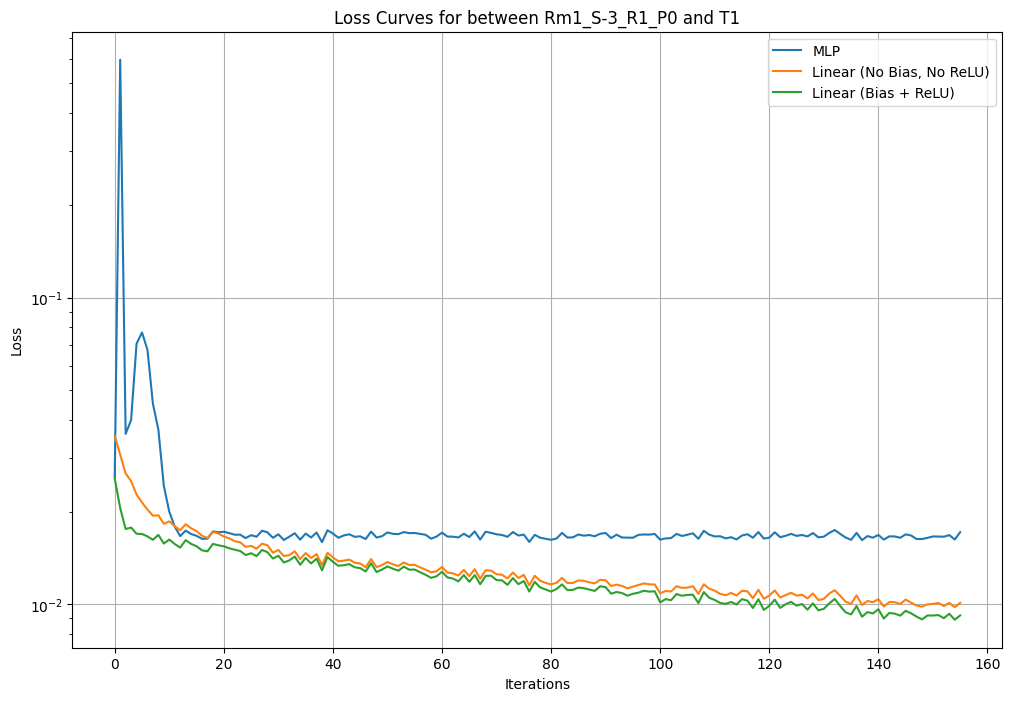

In [7]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear_second = nn.Linear(hidden_size, output_size, bias=bias)
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
    
    def forward(self, x):
        output = self.linear_first(x)
        output = torch.relu(output)
        output = self.linear_second(output)
        return output

def train_model(model, dl, model_name, device, num_epochs=1):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_ind, batch in enumerate(tqdm(dl, desc=f"Epoch {epoch+1}/{num_epochs}")):
            batch = batch.to(device)
            with torch.no_grad():
                feature_acts_upstream = llm[activation_names[0]](batch)
                feature_acts_downstream = llm[activation_names[1]](batch)
                feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
                feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            opt.zero_grad()
            loss = torch.mean(residual**2)
            loss.backward()
            opt.step()
            
            epoch_losses.append(loss.item())
            
            if batch_ind % 10 == 0:
                print(f"{model_name} - Epoch {epoch+1}, Batch {batch_ind}, Loss: {loss.item()}")
        
        losses.extend(epoch_losses)
    
    return losses

# Set up models
res_size, feature_size = sae_upstream.decoder.weight.shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

linear_no_bias_no_relu = Linear(feature_size, bias=False, relu=False)
linear_bias_relu = Linear(feature_size, bias=True, relu=True)
mlp_model = MLP(feature_size, feature_size, feature_size, bias=True)

# Train models
models = [
    (mlp_model, "MLP"),
    (linear_no_bias_no_relu, "Linear (No Bias, No ReLU)"),
    (linear_bias_relu, "Linear (Bias + ReLU)"),
]

all_losses = {}

for model, model_name in models:
    # print GPU torch memory in GB
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9} GB")
    print(f"Training {model_name}...")
    losses = train_model(model.to(device), dl, model_name, device)
    all_losses[model_name] = losses


# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss Curves for between {activation_names[0]} and {activation_names[1]}")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

Training (L2=1e-05):   0%|          | 0/8 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

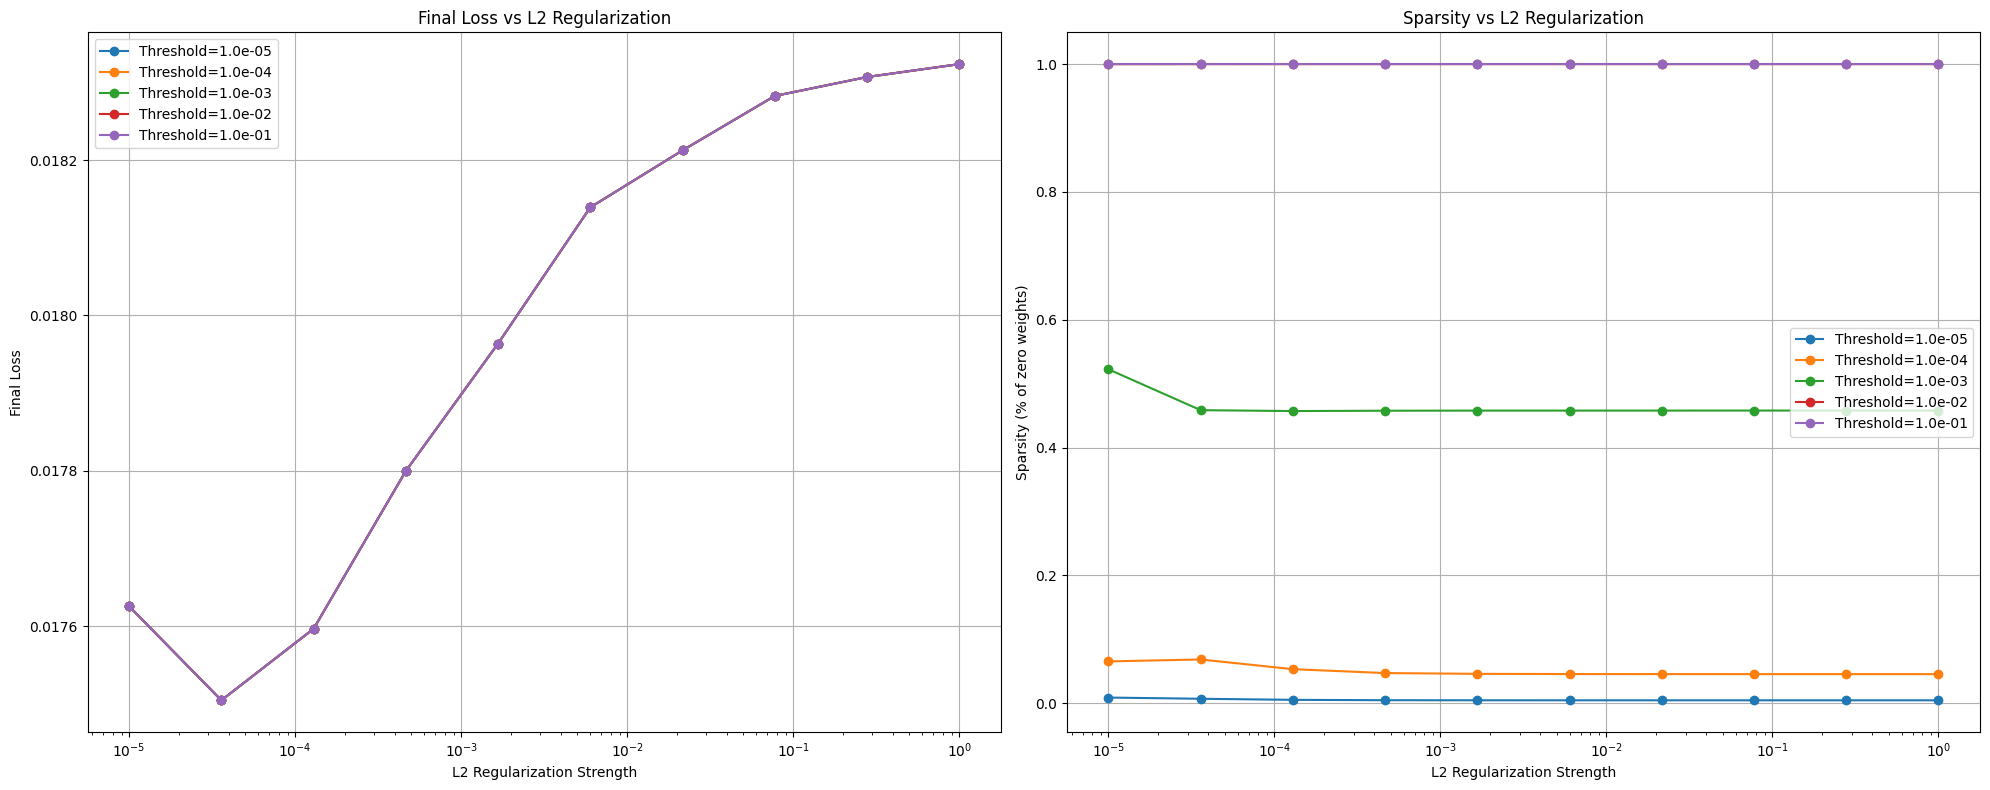

Best loss: 0.0175 (L2=3.59e-05, Threshold=1.00e-05)
Best sparsity: 100.00% (L2=1.00e-05, Threshold=1.00e-01)


In [6]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy

import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm

class Linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output

def train_model(model, dl, device, l2_lambda=0.01):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=l2_lambda)
    losses = []
    
    for batch_ind, batch in enumerate(tqdm(dl, desc=f"Training (L2={l2_lambda})")):
        batch = batch.to(device)
        with torch.no_grad():
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

        x_hat = model(feature_acts_upstream)
        residual = feature_acts_downstream - x_hat
        loss = torch.mean(residual**2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, threshold):
    with torch.no_grad():
        for param in model.parameters():
            param.data[torch.abs(param.data) < threshold] = 0

def get_sparsity(model):
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    return zero_params / total_params

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

l2_values = np.logspace(-5, 0, 10)  # Range of L2 regularization values
threshold_values = np.logspace(-5, -1, 5)  # Range of threshold values

results = []

for l2_lambda in l2_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    final_loss = train_model(model, dl, device, l2_lambda)
    
    for threshold in threshold_values:
        model_copy = deepcopy(model)
        threshold_weights(model_copy, threshold)
        sparsity = get_sparsity(model_copy)
        results.append((l2_lambda, threshold, final_loss, sparsity))

# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot final loss
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Threshold={threshold:.1e}')

ax1.set_xlabel('L2 Regularization Strength')
ax1.set_ylabel('Final Loss')
ax1.set_title('Final Loss vs L2 Regularization')
ax1.legend()
ax1.grid(True)

# Plot sparsity
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax2.semilogx(results_array[mask, 0], results_array[mask, 3], marker='o', label=f'Threshold={threshold:.1e}')

ax2.set_xlabel('L2 Regularization Strength')
ax2.set_ylabel('Sparsity (% of zero weights)')
ax2.set_title('Sparsity vs L2 Regularization')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])

print(f"Best loss: {results_array[best_loss_idx, 2]:.4f} "
      f"(L2={results_array[best_loss_idx, 0]:.2e}, Threshold={results_array[best_loss_idx, 1]:.2e})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(L2={results_array[best_sparsity_idx, 0]:.2e}, Threshold={results_array[best_sparsity_idx, 1]:.2e})")

Training (L2=1e-05):   0%|          | 0/8 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

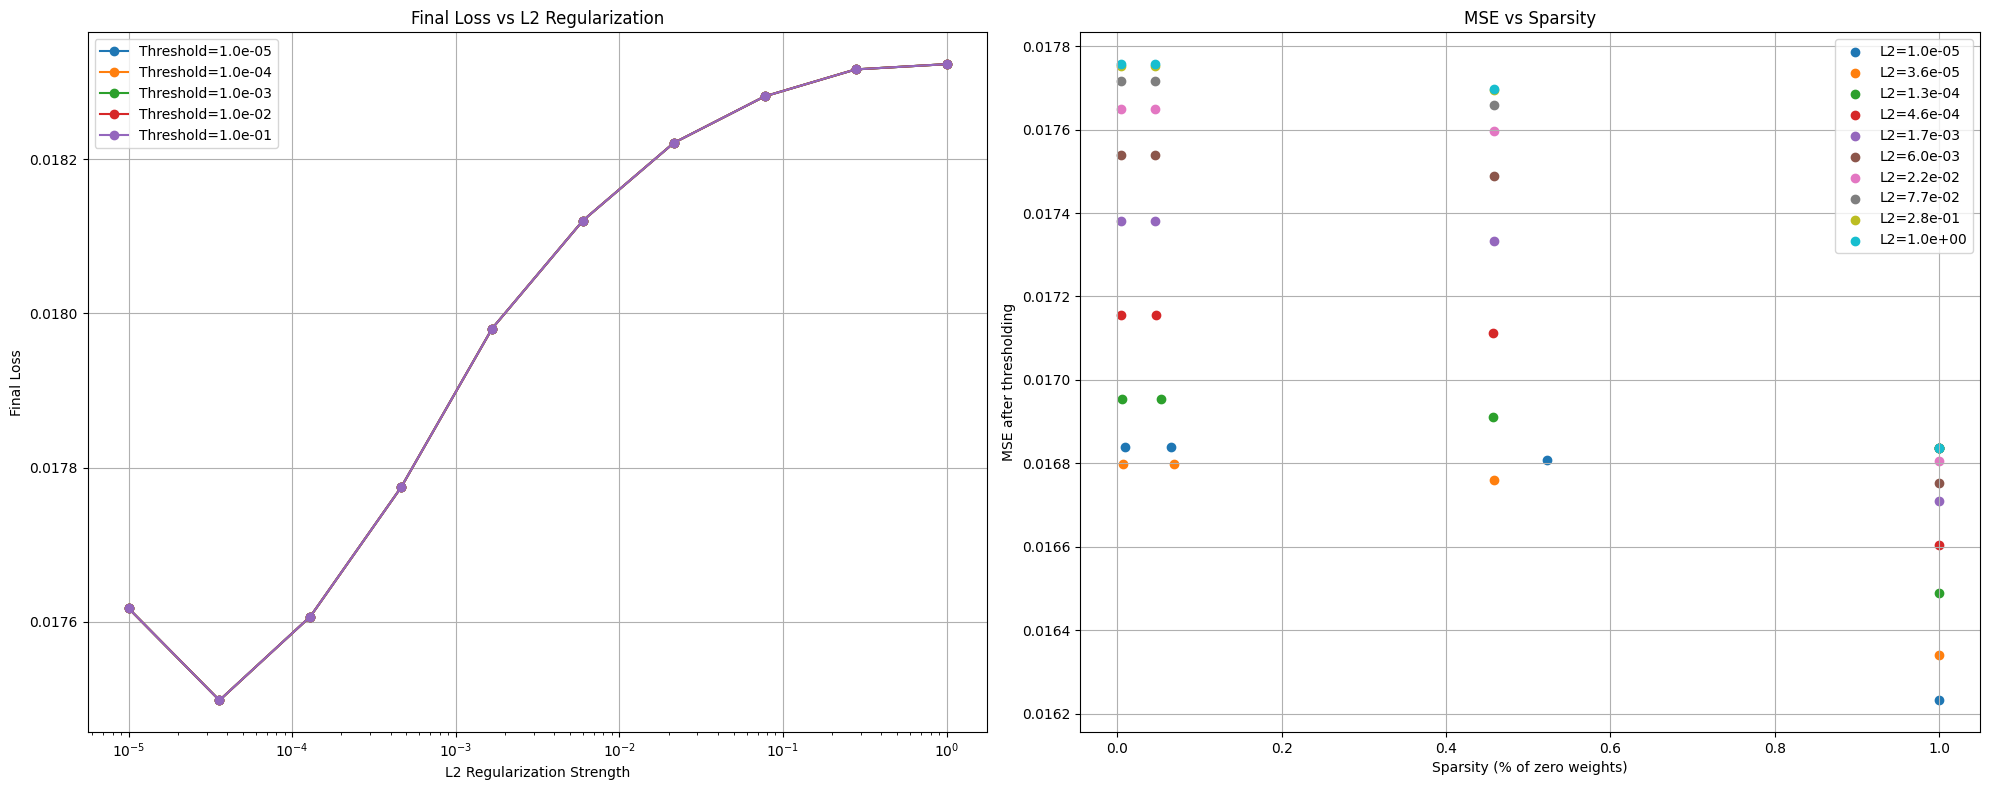

Best initial loss: 0.0175 (L2=3.59e-05, Threshold=1.00e-05)
Best sparsity: 100.00% (L2=1.00e-05, Threshold=1.00e-01)
Best loss after thresholding: 0.0162 (L2=1.00e-05, Threshold=1.00e-02, Sparsity=99.99%)


In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from copy import deepcopy

# Assuming Linear class and other necessary functions are defined as before

def train_model(model, dl, device, l2_lambda=0.01):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=l2_lambda)
    losses = []
    
    for batch_ind, batch in enumerate(tqdm(dl, desc=f"Training (L2={l2_lambda})")):
        batch = batch.to(device)
        with torch.no_grad():
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

        x_hat = model(feature_acts_upstream)
        residual = feature_acts_downstream - x_hat
        loss = torch.mean(residual**2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
    
    return losses[-1]  # Return the final loss

def threshold_weights(model, threshold):
    with torch.no_grad():
        for param in model.parameters():
            param.data[torch.abs(param.data) < threshold] = 0

def get_sparsity(model):
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    return zero_params / total_params

def evaluate_model(model, dl, device, num_batches=3):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dl):
            if i >= num_batches:
                break
            batch = batch.to(device)
            feature_acts_upstream = llm[activation_names[0]](batch)
            feature_acts_downstream = llm[activation_names[1]](batch)
            feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n")
            feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n")

            x_hat = model(feature_acts_upstream)
            residual = feature_acts_downstream - x_hat
            loss = torch.mean(residual**2)
            total_loss += loss.item()
    return total_loss / num_batches

# Set up the experiment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_size, feature_size = sae_upstream.decoder.weight.shape

l2_values = np.logspace(-5, 0, 10)  # Range of L2 regularization values
threshold_values = np.logspace(-5, -1, 5)  # Range of threshold values

results = []

for l2_lambda in l2_values:
    model = Linear(feature_size, bias=False, relu=False).to(device)
    final_loss = train_model(model, dl, device, l2_lambda)
    
    for threshold in threshold_values:
        model_copy = deepcopy(model)
        threshold_weights(model_copy, threshold)
        sparsity = get_sparsity(model_copy)
        new_loss = evaluate_model(model_copy, dl, device)
        results.append((l2_lambda, threshold, final_loss, sparsity, new_loss))

# Convert results to numpy array for easier plotting
results_array = np.array(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot final loss vs L2 regularization
for threshold in threshold_values:
    mask = results_array[:, 1] == threshold
    ax1.semilogx(results_array[mask, 0], results_array[mask, 2], marker='o', label=f'Threshold={threshold:.1e}')

ax1.set_xlabel('L2 Regularization Strength')
ax1.set_ylabel('Final Loss')
ax1.set_title('Final Loss vs L2 Regularization')
ax1.legend()
ax1.grid(True)

# Plot MSE vs Sparsity
for l2_lambda in l2_values:
    mask = results_array[:, 0] == l2_lambda
    ax2.scatter(results_array[mask, 3], results_array[mask, 4], label=f'L2={l2_lambda:.1e}')

ax2.set_xlabel('Sparsity (% of zero weights)')
ax2.set_ylabel('MSE after thresholding')
ax2.set_title('MSE vs Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_loss_idx = np.argmin(results_array[:, 2])
best_sparsity_idx = np.argmax(results_array[:, 3])
best_new_loss_idx = np.argmin(results_array[:, 4])

print(f"Best initial loss: {results_array[best_loss_idx, 2]:.4f} "
      f"(L2={results_array[best_loss_idx, 0]:.2e}, Threshold={results_array[best_loss_idx, 1]:.2e})")
print(f"Best sparsity: {results_array[best_sparsity_idx, 3]:.2%} "
      f"(L2={results_array[best_sparsity_idx, 0]:.2e}, Threshold={results_array[best_sparsity_idx, 1]:.2e})")
print(f"Best loss after thresholding: {results_array[best_new_loss_idx, 4]:.4f} "
      f"(L2={results_array[best_new_loss_idx, 0]:.2e}, Threshold={results_array[best_new_loss_idx, 1]:.2e}, "
      f"Sparsity={results_array[best_new_loss_idx, 3]:.2%})")

In [9]:
model = Linear(feature_size, bias=False, relu=False).to(device)
random_loss = evaluate_model(model, dl, device)
random_loss

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


0.0356332336862882

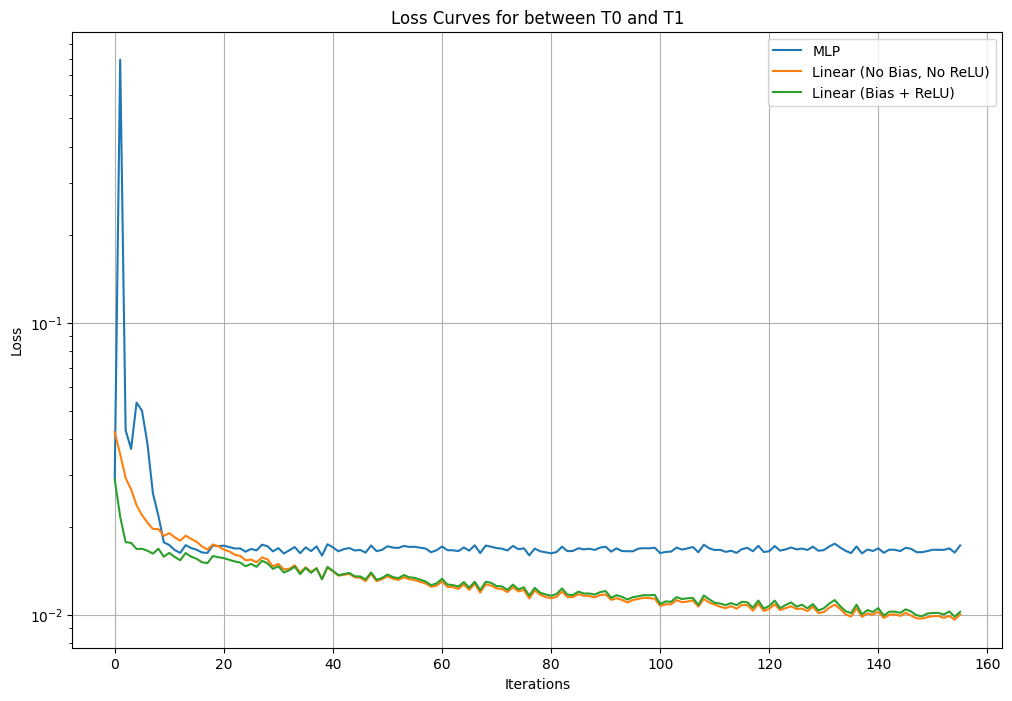

In [6]:
# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss Curves for between {activation_names[0]} and {activation_names[1]}")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

In [10]:
# clear cuda memory
torch.cuda.empty_cache()

for model, model_name in list(models[2:]):
    print(f"Training {model_name}...")
    losses = train_model(model, dl, model_name, device)
    all_losses[model_name] = losses


Training MLP...


Epoch 1/1:   0%|          | 0/78 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.41 GiB. GPU 0 has a total capacity of 47.54 GiB of which 1.66 GiB is free. Process 3242196 has 45.88 GiB memory in use. Of the allocated memory 44.66 GiB is allocated by PyTorch, and 41.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

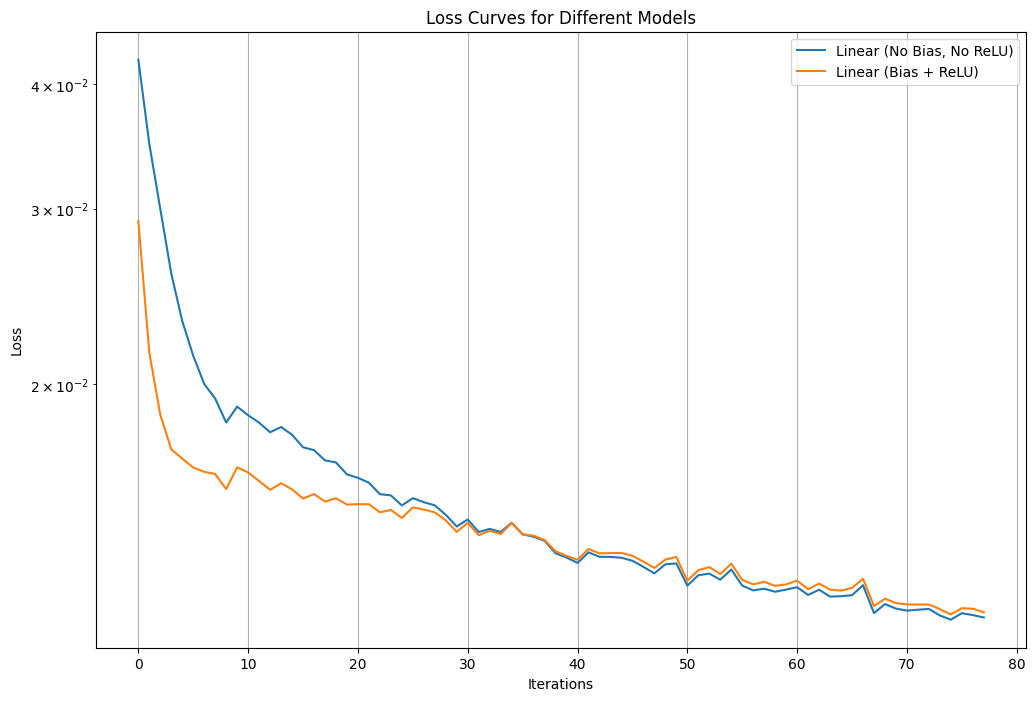

In [6]:
# Plot loss curves
plt.figure(figsize=(12, 8))
for model_name, losses in all_losses.items():
    plt.plot(losses, label=model_name)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Models")
plt.legend()
plt.yscale("log")  # Use log scale for y-axis to better visualize differences
plt.grid(True)
plt.show()

In [18]:
from torch import nn
class linear(nn.Module):
    def __init__(self, input_size, bias=False, relu=False):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        self.relu = relu
    def forward(self, x):
        output = self.linear(x)
        if self.relu:
            return torch.relu(output) 
        return output
    
class mlp(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super().__init__()
        self.linear_first = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear_second = nn.Linear(hidden_size, output_size, bias=bias)
        nn.init.xavier_uniform_(self.linear_first.weight)
        nn.init.xavier_uniform_(self.linear_second.weight)
    def forward(self, x):
        output = self.linear_first(x)
        output = torch.relu(output)
        output = self.linear_second(output)
        return output
    
res_size, feature_size = sae_upstream.decoder.weight.shape
linear_layer = linear(feature_size, bias=False, relu=False).to(device)
opt = torch.optim.Adam(linear_layer.parameters(), lr=1e-3)

In [19]:
for batch_ind, batch in enumerate(tqdm(dl)):
    batch = batch.to(model.device)
    with torch.no_grad():
        feature_acts_upstream = model[activation_names[0]](batch)
        feature_acts_downstream = model[activation_names[1]](batch)
        feature_acts_upstream = rearrange(feature_acts_upstream, "b s n -> (b s) n" )
        feature_acts_downstream = rearrange(feature_acts_downstream, "b s n -> (b s) n" )

    x_hat = linear_layer(feature_acts_upstream)
    residual = feature_acts_downstream - x_hat
    opt.zero_grad()
    loss = torch.mean(residual**2)
    loss.backward()
    opt.step()
    if batch_ind % 10 == 0:
        print(f"Loss: {loss.item()}")

  1%|▏         | 1/78 [00:02<03:20,  2.60s/it]

Loss: 0.04235541447997093


 14%|█▍        | 11/78 [00:28<03:24,  3.06s/it]

Loss: 0.018634028732776642


 27%|██▋       | 21/78 [00:54<02:56,  3.10s/it]

Loss: 0.016137197613716125


 40%|███▉      | 31/78 [01:20<02:24,  3.08s/it]

Loss: 0.014654598198831081


 53%|█████▎    | 41/78 [01:45<01:53,  3.07s/it]

Loss: 0.013249070383608341


 65%|██████▌   | 51/78 [02:11<01:23,  3.10s/it]

Loss: 0.0125730000436306


 78%|███████▊  | 61/78 [02:37<00:52,  3.10s/it]

Loss: 0.012530181556940079


 91%|█████████ | 71/78 [03:03<00:21,  3.11s/it]

Loss: 0.011866397224366665


100%|██████████| 78/78 [03:19<00:00,  2.56s/it]


In [15]:
loss

tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)